# Numerically Controlled Oscillator (NCO)
This notebook is used to develop the NCO which will later be developed in hardware

### Install Dependencies:

In [1]:
pip install matplotlib numpy 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Parameters

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

FS = 48000 # sample rate
N_PA = 32 # phase accumulator bit width
N_SR = 24 # sample rate bit width
MIDI_RANGE = 128 # MIDI takes value x, {0≤x≤127}
A4 = 69 # note A4 is the 69th note (440Hz)

### **Calculate Word Values**
The mathematical equation that relates the output frequency ($F_{out}$​) of a Direct Digital Synthesis (DDS) synthesizer to the tuning word ($M$) is given by:

$F_{out}=\frac{M⋅F_{s}}{2^n}$

#### **Frequency Derivation**
$f(n) = 440\cdot2^{\frac{n-69}{12}}$
A4 (440Hz) is the 69th note

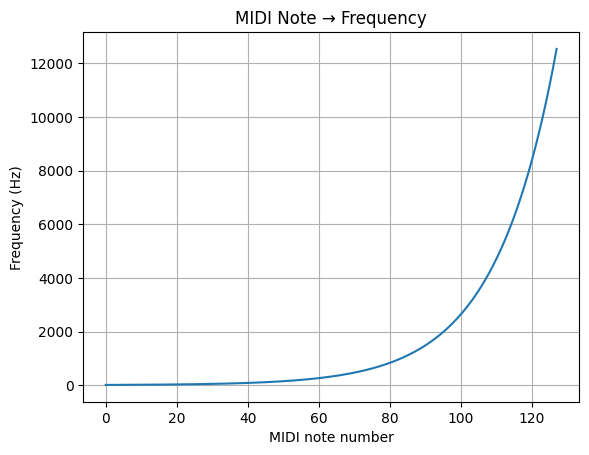

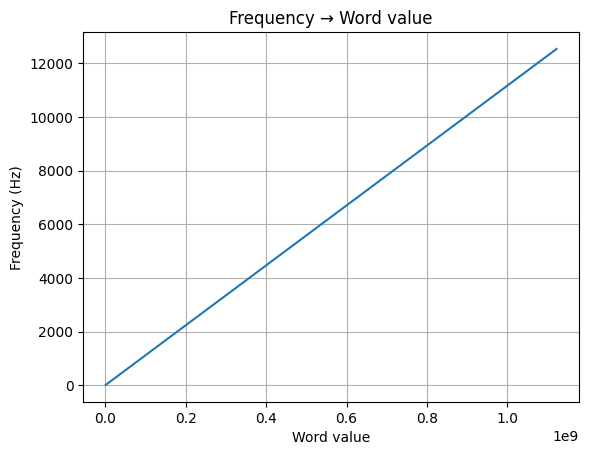

In [3]:
notes = np.arange(MIDI_RANGE)
note_freqs = 440.0 * (2.0 ** ((notes - 69) / 12.0))

pa_words = np.round((note_freqs / FS) * (1 << N_PA)).astype(np.uint32)

# plot midi note to frequency
notes = np.arange(len(note_freqs))
plt.figure()
plt.plot(notes, note_freqs)
plt.xlabel("MIDI note number")
plt.ylabel("Frequency (Hz)")
plt.title("MIDI Note → Frequency")
plt.grid(True)
plt.show()

# plot frequency to word value
plt.figure()
plt.plot(pa_words, note_freqs)
plt.xlabel("Word value")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency → Word value")
plt.grid(True)
plt.show()

### **Naive Look-Up Table (LUT) Construction**
The following table uses a sine wave. The values stored in the table are given by:
$y_k = sin(2\pi k/N)$ where k is an intger between 0 and N where N is $2^{N\_LUT}$

THE LUTs below for the saw, triangle and square are naive implmenetations as they will not perform well at higher octaves due to increased harmonic content in the higher range. This problem will be solved later by implementing *additive synthesis* for generating these LUTs

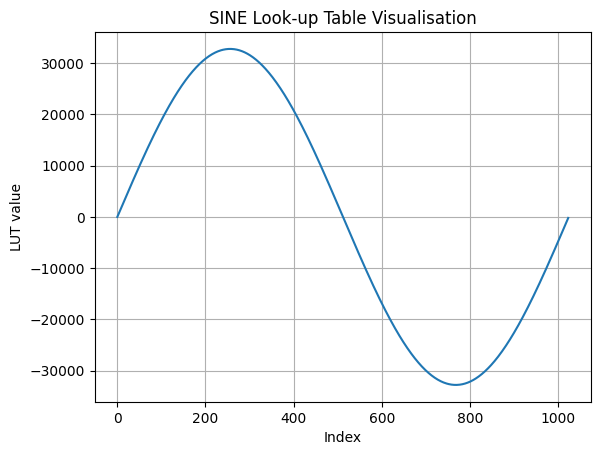

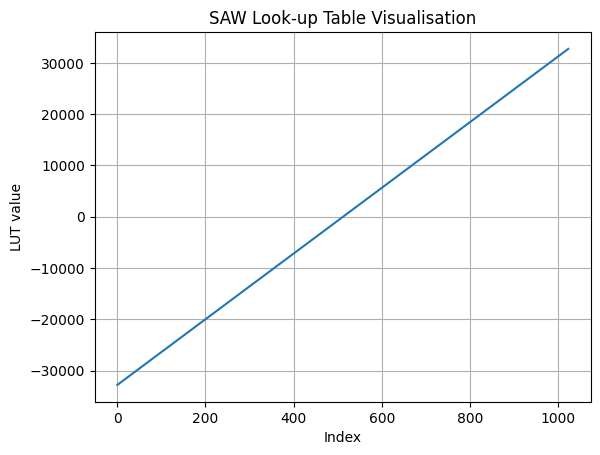

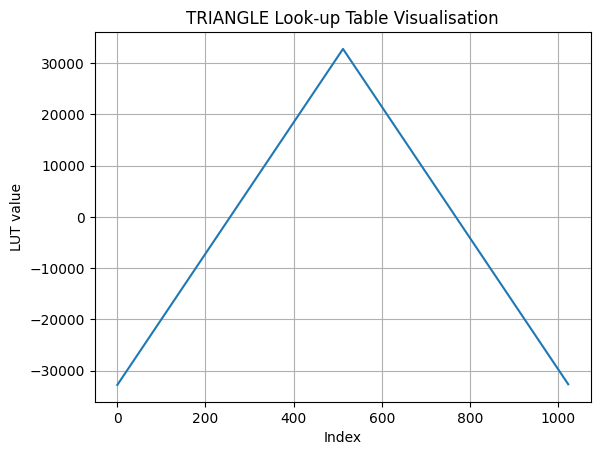

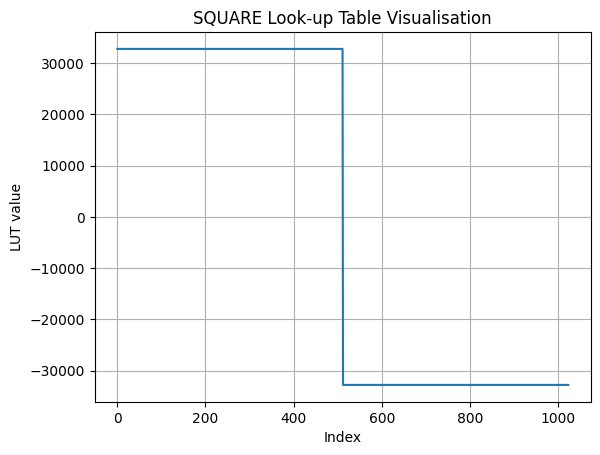

In [4]:
N_LUT = 10 # lookup table bit width (1024 entries)
LUT_LEN = 1 << N_LUT
AMP_BITS = 15  

# SINE WAVE LUT
sin_lut = np.round(
    np.sin(2 * np.pi * np.arange(LUT_LEN) / LUT_LEN)
    * (1 << AMP_BITS)
).astype(np.int32)
# LUT values need to be scaled so that they can be stored as integers to avoid floating point arithmetic

# SAW TOOTH WAVE LUT
saw_lut = np.round(
    (2.0 * (np.arange(LUT_LEN) / LUT_LEN) - 1.0) 
    * (1<<AMP_BITS)
).astype(np.int32)

# TRIANGLE WAVE LUT
k = np.arange(LUT_LEN, dtype=np.float64)
phase_f = k / LUT_LEN
triangle = 1.0 - 4.0 * np.abs(phase_f - 0.5)
triangle_lut = np.round(triangle * (1<<AMP_BITS)).astype(np.int32)

# SQUARE WAVE LUT
first_half = (np.zeros(LUT_LEN // 2) + 1.0)
second_half = (np.zeros(LUT_LEN // 2) - 1.0)
square_lut = np.round(
    np.concatenate((first_half,second_half)) * (1<<AMP_BITS)
).astype(np.int32)

plt.figure()
plt.plot(np.arange(LUT_LEN), sin_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SINE Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), saw_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SAW Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), triangle_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("TRIANGLE Look-up Table Visualisation")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.arange(LUT_LEN), square_lut)
plt.xlabel("Index")
plt.ylabel("LUT value")
plt.title("SQUARE Look-up Table Visualisation")
plt.grid(True)
plt.show()

/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/262179050.py:9: RuntimeWarning: overflow encountered in scalar add
  phase[i] = (phase[i-1] + pa_words[A4]) & mask
/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/262179050.py:12: RuntimeWarning: overflow encountered in scalar add
  phase[i] = (phase[i-1] + pa_words[A4 + 12]) & mask


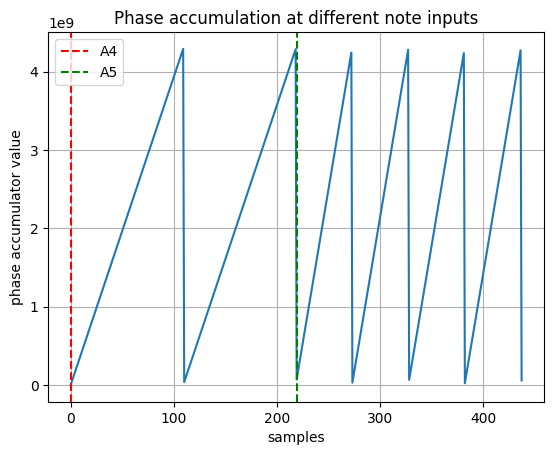

In [17]:
### Phase accumulator
NUM_SAMPLES = 438
phase = np.zeros(NUM_SAMPLES, dtype=np.uint32).astype(np.uint32)

mask = (1 << N_PA) - 1
half = NUM_SAMPLES // 2

for i in range(1, half):
    phase[i] = (phase[i-1] + pa_words[A4]) & mask

for i in range(half, NUM_SAMPLES):
    phase[i] = (phase[i-1] + pa_words[A4 + 12]) & mask

# plot phase accumulator
plt.figure()
plt.plot(np.arange(NUM_SAMPLES), phase)
plt.xlabel("samples")
plt.ylabel("phase accumulator value")
plt.axvline(x=0, color='r', linestyle='--', label='A4')
plt.axvline(x=NUM_SAMPLES//2, color='g', linestyle='--', label='A5')
plt.title("Phase accumulation at different note inputs")
plt.grid(True)
plt.legend()
plt.show()


### **Matching Phase Accumulator value to LUT entry**
In the event that the phase accumulator word size is larger than the bit width of the lookup table, we will have to bit shift the PA word $(N\_PA-N\_LUT)$ bits right in order to index into the table correctly. This operation always rounds down the PA value.

In order to increase the pitch output accuracy, linear interpolation can be used. As we always round down, we can use the last $(N\_PA-N\_LUT)$ bits of the PA word to determine how far we are between the LUT index, $i$, as selected by the first $N\_LUT$ bits and LUT index $i+1$

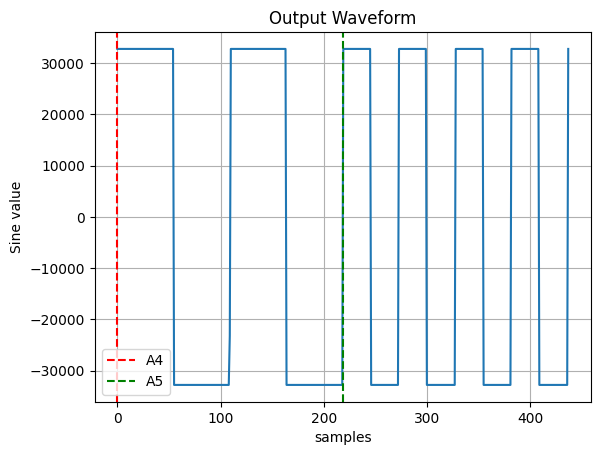

In [18]:
#Left with N_LUT bits. We always truncate (round down) - check the next lut value for linear interpolation

N_FRAC = 10 # use 10 bit accuracy

def lin_interp(lower_index, frac_index, N_FRAC, lut):
    lower = lut[lower_index]
    upper = lut[(lower_index+1) & (len(lut)-1)] # wrap if out of bounds

    diff = upper - lower
    return lower + ((diff * frac_index) >> N_FRAC)

shift_index = N_PA - N_LUT
shift_frac  = N_PA - N_LUT - N_FRAC

idx  = (phase >> shift_index).astype(np.uint32)
frac = ((phase >> shift_frac) & ((1 << N_FRAC) - 1)).astype(np.uint32)

out = np.zeros(NUM_SAMPLES, dtype=np.int32)
for i in range(NUM_SAMPLES):
    out[i] = lin_interp(int(idx[i]), int(frac[i]), N_FRAC, square_lut)


plt.figure()
plt.plot(np.arange(NUM_SAMPLES), out)
plt.xlabel("samples")
plt.ylabel("Sine value")
plt.title("Output Waveform")
plt.axvline(x=0, color='r', linestyle='--', label='A4')
plt.axvline(x=NUM_SAMPLES//2, color='g', linestyle='--', label='A5')
plt.grid(True)
plt.legend()
plt.show()


### **Pitch Validation Testing**

In [8]:
def render_note(note, lut, num_samples, N_PA, N_LUT, N_FRAC, pa_words):
    phase = np.uint32(0)
    M = np.uint32(pa_words[note])

    shift_index = N_PA - N_LUT
    shift_frac  = N_PA - N_LUT - N_FRAC
    frac_mask   = (1 << N_FRAC) - 1

    out = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        phase = np.uint32(phase + M)

        idx = int(phase >> shift_index)                 # 0..1023
        frac = int((phase >> shift_frac) & frac_mask)   # 0..1023

        lower = lut[idx]
        upper = lut[(idx + 1) & (len(lut) - 1)]
        diff  = int(upper) - int(lower)
        out[i] = int(lower) + ((diff * frac) >> N_FRAC)

    return out

def estimate_freq_fft_parabolic(x, FS):
    x = x.astype(np.float64)
    x -= np.mean(x)
    w = np.hanning(len(x))
    X = np.fft.rfft(x * w)
    mag = np.abs(X)
    freqs = np.fft.rfftfreq(len(x), d=1/FS)

    k = np.argmax(mag)

    # guard: peak at edges
    if k == 0 or k == len(mag) - 1:
        return freqs[k]

    # parabolic interpolation on log-magnitude
    a = np.log(mag[k-1] + 1e-12)
    b = np.log(mag[k]   + 1e-12)
    c = np.log(mag[k+1] + 1e-12)
    p = 0.5 * (a - c) / (a - 2*b + c)   # peak offset in bins

    return freqs[k] + p * (freqs[1] - freqs[0])

NUM_SAMPLES = FS * 4  # 1 second

for n in range(0,MIDI_RANGE,5):
    y = render_note(n, sin_lut, int(NUM_SAMPLES), N_PA, N_LUT, N_FRAC, pa_words)
    f_est = estimate_freq_fft_parabolic(y, FS)
    f_target = note_freqs[n]
    err_cents = 1200 * np.log2(f_est / f_target)
    perc_err = ((f_target-f_est)/f_target) * 100
    print(f"note {n:3d}: target={f_target:9.4f} Hz, est={f_est:9.4f} Hz ({err_cents:+.3f} cents), %{perc_err}")


/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/907289491.py:12: RuntimeWarning: overflow encountered in scalar add
  phase = np.uint32(phase + M)


note   0: target=   8.1758 Hz, est=   8.1718 Hz (-0.847 cents), %0.04893544174839611
note   5: target=  10.9134 Hz, est=  10.9096 Hz (-0.598 cents), %0.03452391733803726
note  10: target=  14.5676 Hz, est=  14.5716 Hz (+0.471 cents), %-0.02723166548880652
note  15: target=  19.4454 Hz, est=  19.4418 Hz (-0.325 cents), %0.018787713736783496
note  20: target=  25.9565 Hz, est=  25.9534 Hz (-0.210 cents), %0.012141029951988399
note  25: target=  34.6478 Hz, est=  34.6450 Hz (-0.143 cents), %0.008269483384161629
note  30: target=  46.2493 Hz, est=  46.2493 Hz (-0.002 cents), %0.00011236029799153328
note  35: target=  61.7354 Hz, est=  61.7342 Hz (-0.033 cents), %0.001916917202948134
note  40: target=  82.4069 Hz, est=  82.4034 Hz (-0.073 cents), %0.004219157720014203
note  45: target= 110.0000 Hz, est= 110.0000 Hz (-0.000 cents), %4.247658606263113e-06
note  50: target= 146.8324 Hz, est= 146.8363 Hz (+0.046 cents), %-0.002648599199220248
note  55: target= 195.9977 Hz, est= 195.9975 Hz (-0.

### **Additively Generated Bandwidth-Limited LUTs**

We will need to use multiple tables for each waveform. Standard practice is to create one LUT for each octave.

$K_{max}=\frac{F_s/2}{f_{hi}}$

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

NOTES_PER_BAND = 4

BANDS = np.int16(math.ceil((MIDI_RANGE/NOTES_PER_BAND)))
K_maximums = np.zeros(BANDS, dtype=np.int32)

for i in range(BANDS):
    hi_note = min((i+1)*NOTES_PER_BAND - 1, MIDI_RANGE - 1)  
    K_maximums[i] = int((FS/2) // note_freqs[hi_note])

def generate_square_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1, 2) # odd harmonics
        coeffs = 1.0 / ks                   

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(np.int32(x))
    return luts

def generate_saw_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1)
        coeffs = 1.0 / ks

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(np.int32(x))
    return luts

def generate_triangle_lut(BANDS, K_maximums, N_LUT, AMP_BITS):
    N = 1 << N_LUT
    n = np.arange(N)
    theta = 2*np.pi*n/N

    luts = []
    for i in range(BANDS):
        K = int(K_maximums[i])
        ks = np.arange(1, K+1, 2)
        signs = (-1)**((ks-1)//2)
        coeffs = signs/(ks**2)

        x = np.sum(coeffs[:, None] * np.sin(ks[:, None] * theta[None, :]), axis=0)
        x /= np.max(np.abs(x))
        x *= (1<<AMP_BITS)
        luts.append(np.int32(x))
    return luts

square_luts = generate_square_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)
saw_luts = generate_saw_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)
triangle_luts = generate_triangle_lut(BANDS, K_maximums, N_LUT, AMP_BITS=15)

WAVESETS = {
    "square": square_luts,
    "saw": saw_luts,
    "triangle": triangle_luts,
}

band0 = 0
wave0 = "square"

N_BANDS = len(square_luts)
LUT_LEN = len(square_luts[0])

# --- widgets ---
band_slider = widgets.IntSlider(
    value=band0,
    min=0,
    max=N_BANDS - 1,
    step=1,
    description="Band",
    continuous_update=True
)

wave_radio = widgets.ToggleButtons(
    options=list(WAVESETS.keys()),
    value=wave0,
    description="Wave",
)

ui = widgets.VBox([wave_radio, band_slider])

# --- output area ---
out = widgets.Output()

def render_plot(wave, band):
    lut = WAVESETS[wave][band]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(np.arange(LUT_LEN), lut)
    ax.set_title(f"{wave} | band={band} | K_max={K_maximums[band]}")
    ax.set_xlabel("Index")
    ax.set_ylabel("Amplitude")
    ax.grid(True)
    plt.show()

def update(*_):
    with out:
        clear_output(wait=True)
        render_plot(wave_radio.value, int(band_slider.value))

# hook callbacks
band_slider.observe(update, names="value")
wave_radio.observe(update, names="value")

# initial draw
update()

display(ui, out)


Output()

In [23]:
from IPython.display import Audio

def to_int16(x):
    x = np.asarray(x)
    # if it's float in some range, normalize first
    if np.issubdtype(x.dtype, np.floating):
        x = x / np.max(np.abs(x) + 1e-12)
        return np.int16(np.clip(x, -1, 1) * 32767)
    # if it's int scaled like AMP_BITS=15
    return np.int16(np.clip(x, -32768, 32767))

DUR = 2.0
NUM_SAMPLES = int(FS * DUR)

note = 34
band = note // 12
lut = sin_lut.astype(np.int32)
lut1 = square_luts[band].astype(np.int32) 
lut2 = saw_luts[band].astype(np.int32)
lut3 = triangle_luts[band].astype(np.int32)

y = render_note(note, lut2, NUM_SAMPLES, N_PA, N_LUT, N_FRAC, pa_words)
y16 = to_int16(y)
Audio(y16, rate=FS)


/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/907289491.py:12: RuntimeWarning: overflow encountered in scalar add
  phase = np.uint32(phase + M)


In [63]:
from enum import Enum

luts = [square_luts, saw_luts, triangle_luts]

class Waveform(Enum):
    SINE = -1
    SQUARE = 0
    SAW = 1
    TRIANGLE = 2

def play_note(midi_note, waveform: Waveform, duration):
    num_samples = int(FS * duration)

    if waveform == Waveform.SINE:
        lut = sin_lut
    else:
        w = waveform.value
        band = midi_note >> 2
        band = min(band, len(luts[w]) - 1)
        lut = luts[w][band]

    # power-of-two LUT assumption (good for FPGA-style)
    L = len(lut)
    assert (L & (L - 1)) == 0, "LUT length must be power of two"

    phase = np.uint32(0)
    M = np.uint32(pa_words[midi_note])

    shift_index = N_PA - N_LUT
    shift_frac  = N_PA - N_LUT - N_FRAC
    frac_mask   = (1 << N_FRAC) - 1

    out = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        phase = np.uint32(phase + M)

        idx  = int(phase >> shift_index)
        frac = int((phase >> shift_frac) & frac_mask)

        lower = int(lut[idx])
        upper = int(lut[(idx + 1) & (L - 1)])
        out[i] = lower + (((upper - lower) * frac) >> N_FRAC)

    return out

play_note(40, Waveform.TRIANGLE, 0.02)


/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/1185886559.py:36: RuntimeWarning: overflow encountered in scalar add
  phase = np.uint32(phase + M)


array([   224,    450,    675,    901,   1126,   1351,   1577,   1802,
         2028,   2253,   2479,   2704,   2929,   3155,   3380,   3606,
         3831,   4056,   4282,   4507,   4733,   4958,   5183,   5408,
         5634,   5859,   6085,   6310,   6535,   6761,   6986,   7212,
         7437,   7662,   7888,   8113,   8338,   8564,   8790,   9016,
         9241,   9466,   9692,   9917,  10143,  10367,  10593,  10818,
        11044,  11269,  11494,  11720,  11945,  12171,  12396,  12621,
        12847,  13072,  13298,  13523,  13748,  13974,  14199,  14425,
        14650,  14875,  15100,  15326,  15552,  15776,  16002,  16227,
        16453,  16678,  16904,  17129,  17354,  17581,  17806,  18031,
        18257,  18482,  18708,  18933,  19158,  19384,  19609,  19835,
        20059,  20285,  20510,  20735,  20961,  21186,  21412,  21637,
        21863,  22088,  22313,  22539,  22764,  22990,  23215,  23441,
        23666,  23891,  24117,  24341,  24568,  24793,  25018,  25244,
      

In [72]:
sine_audio = np.concatenate([
    play_note(i, Waveform.SINE, 0.1)
    for i in range(MIDI_RANGE)
])

saw_audio = np.concatenate([
    play_note(i, Waveform.SAW, 0.1)
    for i in range(MIDI_RANGE)
])

square_audio = np.concatenate([
    play_note(i, Waveform.SQUARE, 0.1)
    for i in range(MIDI_RANGE)
])

triangle_audio = np.concatenate([
    play_note(i, Waveform.TRIANGLE, 0.1)
    for i in range(MIDI_RANGE)
])

/var/folders/1v/3hwqnjl53hzft3hxxkcrv1w00000gn/T/ipykernel_75584/1185886559.py:36: RuntimeWarning: overflow encountered in scalar add
  phase = np.uint32(phase + M)


In [74]:
y_saw = to_int16(sine_audio)
Audio(y_saw, rate=FS)
